In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy
import numpy as np
import ipywidgets as widgets
import os, glob

from scipy import optimize
from scipy.optimize import minimize, minimize_scalar, curve_fit
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output

In [73]:
# Load the data (CSV format)

# df = pd.read_csv('Queensland_2023_fireball_data.csv', names = ["No", "Station ID", "Ignore", "Time", "JD", "meas1", "meas2", "Azim +E of due N", "Alt", "Azim line", "Alt line", "RA obs", "Dec obs", "RA line", "Dec line", "X", "Y", "Z", "Latitude", "Longitude", "Height", "Range", "Length", "State vect dist", "Lag", "Velocity", "Vel prev avg", "H res", "V res", "Ang res", "AppMag", "AbsMag"])
# df = pd.read_csv('Tekapo_2024_fireball_data.csv', names = ["No", "Station ID", "Ignore", "Time", "JD", "meas1", "meas2", "Azim +E of due N", "Alt", "Azim line", "Alt line", "RA obs", "Dec obs", "RA line", "Dec line", "X", "Y", "Z", "Latitude", "Longitude", "Height", "Range", "Length", "State vect dist", "Lag", "Velocity", "Vel prev avg", "H res", "V res", "Ang res", "AppMag", "AbsMag"])
df = pd.read_csv('Winchcombe_fireball_data.csv', names = ["No", "Station ID", "Ignore", "Time", "JD", "meas1", "meas2", "Azim +E of due N", "Alt", "Azim line", "Alt line", "RA obs", "Dec obs", "RA line", "Dec line", "X", "Y", "Z", "Latitude", "Longitude", "Height", "Range", "Length", "State vect dist", "Lag", "Velocity", "Vel prev avg", "H res", "V res", "Ang res", "AppMag", "AbsMag"])

# df = pd.read_csv('Pribram_fireball_data.csv', names = ["Source", "Height", "Velocity"])
# df = pd.read_csv('Lost_City_fireball_data.csv', names = ["Source", "Height", "Velocity"])
# df = pd.read_csv('Innisfree_fireball_data.csv', names = ["Source", "Height", "Velocity"])

# Provide event name

event = "Winchcombe"

In [74]:
# Remove rows with empty cells
df = df.dropna()
df = df.drop(0, axis='index')

print(df.head())
print(df.tail())
print(df.info())

  No         Station ID Ignore      Time           JD      meas1     meas2  \
1  0   Hullavington_end      0   6.28066  2459274.413  331.55593   76.2895   
2  1   Hullavington_end      0  6.320692  2459274.413  330.51725  76.21503   
3  2   Hullavington_end      0  6.360724  2459274.413  328.53854  76.06407   
4  3   Hullavington_end      0  6.400756  2459274.413  326.98291  75.96838   
5  4   Hullavington_end      0  6.440788  2459274.413  325.68881  75.86714   

  Azim +E of due N       Alt  Azim line  ...   Length State vect dist  \
1        352.26759  38.93208   352.2298  ...        0        83094.18   
2        352.53185  38.77676  352.50268  ...   295.29        83389.47   
3        353.04241   38.4795  353.03094  ...   852.58        83946.76   
4        353.46253  38.27459  353.43973  ...  1287.07        84381.25   
5        353.81017  38.08827  353.78566  ...  1656.99        84751.17   

        Lag  Velocity Vel prev avg   H res   V res Ang res AppMag AbsMag  
1  -3456.68      

In [75]:
# Remove rows in which velocity is zero
mask = df['Velocity'] == '0'
df = df[~mask]

# Sort by height, highest to lowest
df_sorted = df.sort_values(by="Height", ascending=False, ignore_index=True)

print(df_sorted["Height"], df_sorted["Velocity"])

0      90304.56
1      90015.55
2       89662.1
3      89282.91
4       88892.7
         ...   
509    27953.54
510    27848.27
511    27742.76
512    27632.83
513     27554.2
Name: Height, Length: 514, dtype: object 0      11185.12
1      10990.71
2      13428.91
3      14422.28
4      14827.68
         ...   
509     4862.34
510     4055.64
511     4069.27
512     4235.41
513     3032.63
Name: Velocity, Length: 514, dtype: object


In [76]:
# Get number of rows containing numerical data (header row is 0)
rows = len(df_sorted)

h0 = float(7160) # Exponential atmosphere critical height
he = float(df_sorted['Height'][0]) # entry height in m
ht = float(df_sorted['Height'][rows-1]) # terminal height in m

ve = float(df_sorted['Velocity'][0]) # entry velocity in m/s
vt = float(df_sorted['Velocity'][rows-1]) # terminal velocity in m/s

# Set initial velocity as mean of first 5 points
ve = (float(df_sorted['Velocity'][0]) + float(df_sorted['Velocity'][1]) + float(df_sorted['Velocity'][2]) + float(df_sorted['Velocity'][3]) + float(df_sorted['Velocity'][4]))/5

print("Fireball entry height =", he, "m")
print("Terminal height =", ht, "m")
print("Entry velocity =", ve, "m/s")
print("Terminal velocity =", vt, "m/s")

# Check outputs against the table printed above before moving on!

Fireball entry height = 90304.56 m
Terminal height = 27554.2 m
Entry velocity = 12970.94 m/s
Terminal velocity = 3032.63 m/s


In [77]:
# Normalise heights to exponential atmosphere
y = he/h0 # normalised entry height
yt = ht/h0 # normalised terminal height
alt = np.array(df_sorted['Height'], dtype='float')
Yvalues = alt/h0

In [78]:
# Normalise velocity values
vel = np.array(df_sorted['Velocity'], dtype='float')
Vvalues = vel/ve

In [79]:
# Flight parameters and constants
mu = 2/3. # rotation factor
Ae = 1.209 # shape factor
g = 9.81 # acceleration due to gravity in m/s/s
Cd = 1 # drag coefficient
Ca = 0.04 # ablation coefficient; use 0.02 for ordinary chondrites, 0.04 for carb/enstatite chondrites
D0 = 1.29 # critical density of exponential atmosphere
pi = 3.14159265358979
e = 2.718281828459045

# Define initial mass, meteoroid density and angle of entry, if known:
m = 1 # entry mass in kg
Dm = 2120 # meteoroid density in kg/m3
slope = 41.8 # angle above horizontal, in degrees
gamma = (slope*2*pi)/360 # angle above horizontal, in radians
siny = math.sin(gamma)

print("Entry mass =", m, "kg estimated")
print("Entry angle =", slope, "degrees,", gamma, "radians above horizontal")

Entry mass = 1 kg estimated
Entry angle = 41.8 degrees, 0.729547627333629 radians above horizontal


In [86]:
# Define alpha and beta minimisation functions from Gritsevich (2007)

def alpha_beta_Q4_min(Vvalues, Yvalues):
    params = np.vstack((Vvalues, Yvalues))
    b0 = 1.
    a0 = np.exp(Yvalues[-1])/(2*b0)
    x0 = [a0, b0]
    xmin = [0.0001, 0.000001]
    xmax = [10000, 50]
    bnds = ((xmin[0], xmax[0]), (xmin[1], xmax[1]))
    res = scipy.optimize.minimize(alpha_beta_min_fun, x0, args=(Vvalues, Yvalues), bounds=bnds)
    return res.x

def alpha_beta_min_fun(x, vvals, yvals): # Equation 7 in Gritsevich (2007)
    res = 0
    for i in range(len(vvals)):
        res += pow(2*x[0]*np.exp(-yvals[i]) - (scipy.special.expi(x[1]) - scipy.special.expi(x[1]*vvals[i]**2))*np.exp(-x[1]), 2)
    return res

def Q4_min_v(velocities, heights, h0, V0, err=[]):
    Yvalues = [j / h0 for j in heights] # normalisation of heights here
    print(len(velocities))
    b0 = 0.01
    a0 = np.exp(Yvalues[-1])/(2. * b0)
    x0 = [a0, b0, V0/10000]
    xmin = [0.01, 0.00001, V0 * 0.99/10000] # /1000 is a hack to make velocities small so minimisation doesnt use stupid steps
    xmax = [1000., 1000., V0 * 1.01/10000]
    bnds = ((xmin[0], xmax[0]), (xmin[1], xmax[1]), (xmin[2], xmax[2]))
    res = minimize(min_fun_v, x0, args=(velocities, Yvalues, err),bounds=bnds)
    out = res.x
    out[2]*=10000. # fix velocities for return
    return out   

def min_fun_v(x, velocities, yvals,err):
    res = []
    for i in range(len(velocities)):
        vval = velocities[i] / (x[2]*10000.)
        res.append(pow(2 * x[0] * np.exp(-yvals[i]) - (scipy.special.expi(x[1]) - scipy.special.expi(x[1]* vval**2) ) * np.exp(-x[1]) , 2))
    
    # print(velocities[0], x, np.nansum(res))
    return np.nansum(res)

def minimizeAlphaBeta_v(v_data, ht_normed, v_init):
    def _alphaBetaMinimization(x, v_data, ht_normed):
        # Normalize the velocity
        v_normed = v_data/(x[2]*1000.)
        alpha = x[0]
        beta = x[1]

        # Compute the sum of absolute residuals (more robust than squared residuals)
        res = np.sum(np.abs(2*alpha*np.exp(-ht_normed) \
                         - (scipy.special.expi(beta) \
                            - scipy.special.expi(beta*v_normed**2))*np.exp(-beta)))
        return res

    # Compute initial alpha-beta guess
    b0 = 1.0
    a0 = np.exp(ht_normed[-1])/(2.0*b0)
    x0 = [a0, b0, v_init/1000.]

    # Set alpha-beta limits
    xmin = [0.001, 0.00001, v_init * 0.9/1000] # /1000 is a hack to make velocities small so minimisation doesnt use stupid steps
    xmax = [10000., 50., v_init * 1.1/1000]
    bnds = ((xmin[0], xmax[0]), (xmin[1], xmax[1]), (xmin[2], xmax[2]))

    # Compute best-fit alpha-beta values
    res = scipy.optimize.minimize(_alphaBetaMinimization, x0, args=(v_data, ht_normed), bounds=bnds)
    return res.x

def fitAlphaBeta_v(v_data, ht_data, v_init=None):
    # Compute the initial velocity, if it wasn't given already
    if v_init is None:
        max_index = int(0.2*len(v_data))
        if max_index < 10:
            max_index = 10
        v_init = np.median(v_data[:max_index])

    # Normalize the height
    ht_normed = ht_data/HT_NORM_CONST

    # Fit alpha and beta
    alpha, beta, v_init =  minimizeAlphaBeta_v(v_data, ht_normed, v_init)
    v_init *= 1000.
    return v_init, alpha, beta

In [87]:
# Calculate alpha and beta from minimisation functions

Gparams = alpha_beta_Q4_min(Vvalues, Yvalues)
alpha = Gparams[0]
beta = Gparams[1]
print(alpha, beta)

41.55958888778134 0.3283300029521132


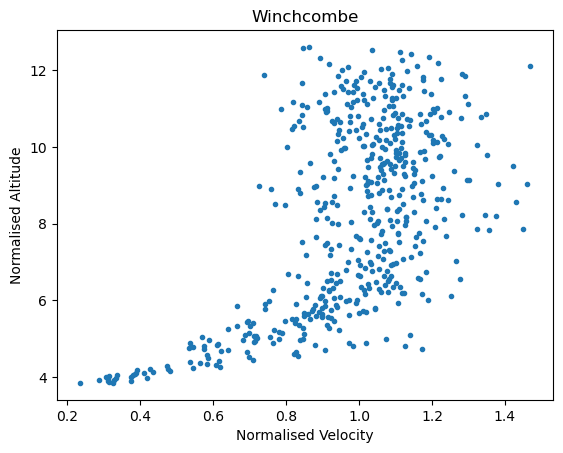

In [88]:
# Display meteoroid velocity vs height
plt.scatter(Vvalues, Yvalues, marker='.', label=None)
plt.title(event)
plt.xlabel("Normalised Velocity")
plt.ylabel("Normalised Altitude")
plt.show()

In [90]:
x = np.arange(0.1, 1, 0.0005);

def f(V0, alpha, beta):
    res = alpha_beta_min_fun([alpha, beta, ve], Vvalues, Yvalues)
    Vvals = vel/V0
    plt.scatter(Vvals, Yvalues, marker='.', label=None)
    y = np.log(alpha) + beta - np.log((scipy.special.expi(beta) - scipy.special.expi(beta*x**2))/2)
    plt.plot(x, y, color='g')
    plt.show()
    return(alpha, beta, V0)

out = interact(f, V0=(ve*0.5, ve*1.5, 0.5), alpha=(0.01, 400, 0.1), beta=(0.001, 5, 0.001))

interactive(children=(FloatSlider(value=12970.470000000001, description='V0', max=19456.41, min=6485.47, step=…

In [91]:
alpha_fit = out.widget.result[0]
beta_fit = out.widget.result[1]
v_fit = out.widget.result[2]

print(alpha_fit, beta_fit, v_fit)

199.91 2.5 12970.470000000001


In [92]:
# Calculate essential outputs

lna = math.log(alpha_fit)
lnasiny = math.log(alpha_fit*siny)
lnb = math.log(beta_fit)
log2ab = math.log10(2*alpha_fit*beta_fit)
Ca = (2*beta_fit)/((v_fit/1000)*(v_fit/1000)*(1-mu)) # Ablation coefficient in kg/MJ
Me = ((0.5*Cd*D0*h0*Ae)/(alpha_fit*siny*(Dm**(2/3.))))**3 # Entry mass in kg (spherical shape assumed?)
Se = (2*alpha_fit*siny*Me)/(Cd*D0*h0) # Cross-sectional surface area in m2

print(event)
print("ln(alpha) =", round(lna, 2))
print("ln(alpha.sin(gamma)) =", round(lnasiny, 2))
print("ln)beta =", round(lnb, 2))
print("log2_alpha_beta =", round(log2ab, 2))
print("Entry mass =", (round(Me, 2)), "kg")
print("Ablation coefficient =", (round(Ca, 4)), "kg/MJ")
print("Sectional area at entry =", (round(Se, 4)), "m2")

Winchcombe
ln(alpha) = 5.3
ln(alpha.sin(gamma)) = 4.89
ln)beta = 0.92
log2_alpha_beta = 3.0
Entry mass = 0.02 kg
Ablation coefficient = 0.0892 kg/MJ
Sectional area at entry = 0.0005 m2


In [ ]:
# Created by T.W.C. Stevenson, May 2024
# References:
# 